In [1]:
import pandas as pd
import numpy as np

file = "../data/linkedin.csv"

df = pd.read_csv(file, low_memory=False, parse_dates=[0])

df.head(2)

,Date,Post ID,Network,Post Type,Content Type,Profile,Sent by,Link,Post,Linked Content,...,Video Removed from Playlists,Annotation Impressions,Annotation Clickable Impressions,Annotation Closable Impressions,Annotation Closes,Card Impressions,Card Teaser Impressions,Card Teaser Clicks,Poll Votes,Tags
0,7/13/2023 12:03 pm,7085212016608456704,LinkedIn,Post,Photo,Stanbic IBTC,Blessing Ubah,https://linkedin.com/feed/update/urn:li:share:...,Your money should not be a gamble. Before you ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIB Posts
1,7/12/2023 8:00 pm,7084969706025009152,LinkedIn,Post,Text,Stanbic IBTC,Blessing Ubah,https://linkedin.com/feed/update/urn:li:share:...,"What skill (s) do you have, that no one ever t...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Optimized the date column for data cleaning
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y %I:%M %p")

In [3]:
# increase pandas default max_rows so I can view all columns at once
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [4]:
df.shape  # Number of rows and columns befor data cleaning

(7760, 147)

In [5]:
%cd ..

/Users/pablo/Documents/Documents - Peter’s MacBook Pro/GitHub/Hack the Feed/hack-the-feed/hack-the-feed


In [6]:
# Data Cleaning
from src.clean_data import clean_df

In [7]:
linkedin_df = clean_df(df)

In [8]:
linkedin_df.head()

,Content Type,Sent by,Link,Post,Linked Content,Impressions,Organic Impressions,Engagement Rate (per Impression),Engagements,Reactions,Likes,Comments,Shares,Click-Through Rate,Post Link Clicks,Post Clicks (All),Video Views,Organic Video Views,Poll Votes,Tags,Time,Time Period
Date,,,,,,,,,,,,,,,,,,,,,,
2014-05-05,Link,,https://linkedin.com/feed/update/urn:li:activi...,"""How small businesses can leverage the supply ...",http://www.thisdaylive.com/articles/stanbic-ib...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:57:00,morning
2014-05-06,Link,,https://linkedin.com/feed/update/urn:li:activi...,Do you own a business? Here's something on how...,http://socialmediatoday.com/1876456/why-your-b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:40:00,afternoon
2014-05-07,Link,,https://linkedin.com/feed/update/urn:li:activi...,Are professional advisers important for small ...,http://www.forbes.com/sites/sage/2014/04/21/do...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:28:00,afternoon
2014-05-08,Photo,,https://linkedin.com/feed/update/urn:li:activi...,When going for an interview these tips might b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14:15:00,afternoon
2014-05-09,Photo,,https://linkedin.com/feed/update/urn:li:activi...,We understand that as a Nigerian living outsid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:24:00,morning


In [9]:
linkedin_df.shape  # Number of rows and columns after data cleaning

(7760, 22)

In [10]:
linkedin_df.columns

Index(['Content Type', 'Sent by', 'Link', 'Post', 'Linked Content',
       'Impressions', 'Organic Impressions',
       'Engagement Rate (per Impression)', 'Engagements', 'Reactions', 'Likes',
       'Comments', 'Shares', 'Click-Through Rate', 'Post Link Clicks',
       'Post Clicks (All)', 'Video Views', 'Organic Video Views', 'Poll Votes',
       'Tags', 'Time', 'Time Period'],
      dtype='object')

In [11]:
features_after_cleaning = list(
    linkedin_df.columns
)  # list of features after data cleaning

In [12]:
len(features_after_cleaning)  # Number of features after data cleaning

22

In [13]:
list_features = list(df.columns)  # list of features before data cleaning

In [14]:
len(list_features) - len(
    features_after_cleaning
)  # 126 features did not have values in them

126

In [15]:
linkedin_df.info()  # A conscise summary of the cleaned dataframe

<class 'pandas.core.frame.DataFrame'>
Index: 7760 entries, 2014-05-05 to 2023-07-13
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Content Type                      7760 non-null   object 
 1   Sent by                           7760 non-null   object 
 2   Link                              7756 non-null   object 
 3   Post                              7729 non-null   object 
 4   Linked Content                    107 non-null    object 
 5   Impressions                       6332 non-null   float64
 6   Organic Impressions               6332 non-null   float64
 7   Engagement Rate (per Impression)  6332 non-null   object 
 8   Engagements                       6332 non-null   float64
 9   Reactions                         6332 non-null   float64
 10  Likes                             6332 non-null   float64
 11  Comments                          6332 non-null   float64
 

In [16]:
# I need to convert the Engagement Rate (per Impression) data type to floats
linkedin_df["Engagement Rate (per Impression)"].tail()

Date
2023-07-11    5.05%
2023-07-11    1.83%
2023-07-12    9.52%
2023-07-12      NaN
2023-07-13      NaN
Name: Engagement Rate (per Impression), dtype: object

In [17]:
# Remove the '%' sign
linkedin_df["Engagement Rate (per Impression)"] = linkedin_df[
    "Engagement Rate (per Impression)"
].str.replace("%", "")

# Remove the comma ','
# insta_df['Engagement Rate (per Impression)'] = insta_df['Engagement Rate (per Impression)'].str.replace(',', '')


# Convert to float
linkedin_df["Engagement Rate (per Impression)"] = linkedin_df[
    "Engagement Rate (per Impression)"
].astype(float)

In [18]:
linkedin_df.info()  # Confirm the data type change

<class 'pandas.core.frame.DataFrame'>
Index: 7760 entries, 2014-05-05 to 2023-07-13
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Content Type                      7760 non-null   object 
 1   Sent by                           7760 non-null   object 
 2   Link                              7756 non-null   object 
 3   Post                              7729 non-null   object 
 4   Linked Content                    107 non-null    object 
 5   Impressions                       6332 non-null   float64
 6   Organic Impressions               6332 non-null   float64
 7   Engagement Rate (per Impression)  6332 non-null   float64
 8   Engagements                       6332 non-null   float64
 9   Reactions                         6332 non-null   float64
 10  Likes                             6332 non-null   float64
 11  Comments                          6332 non-null   float64
 

## Analysis and Visualization

### Impressions and Reach

The following sub-sections provide insights on the Impressions, Reach, and Engagements of the LinkedIn posts.

QUESTION: What type of content generates the most impressions?

In [19]:
# create a slice of the dataframe containing non-zero values for the `Impression` column.
valid_impressions = linkedin_df[
    (linkedin_df["Impressions"] != 0) & ~linkedin_df["Impressions"].isna()
]

# group by `Content Type` and calculate the mean `Impressions for each content type
content_df = (
    valid_impressions.groupby("Content Type")["Impressions"]
    .mean()
    .reset_index()
    .sort_values("Impressions", ascending=False)
)

In [20]:
# import necessary plotting libraries
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [21]:
# create a bar chart showing the average impressions by content type
from bokeh.plotting import figure, output_file, show

x_range = content_df["Content Type"]
y_range = content_df["Impressions"]

p = figure(
    title="Average Impressions by Content Type",
    x_range=x_range,
    height=400,
    width=600,
    y_axis_label="Average Impression",
)

p.vbar(x=x_range, top=y_range, width=0.8)

p.yaxis.minor_tick_out = 0
p.y_range.start = 1000

show(p)

### Question: What is the the trend of impressions over the years?

In [22]:
# import relevant plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

In [23]:
# I reseted the index and renamed it to date
valid_impressions.reset_index(inplace=True)
valid_impressions.rename(columns={"index": "date"}, inplace=True)

/var/folders/sj/vpbs2tm52r3gw6r1vgvt92200000gn/T/ipykernel_49995/2969413702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_impressions.rename(columns={"index": "date"}, inplace=True)


In [24]:
valid_impressions.head(2)

,Date,Content Type,Sent by,Link,Post,Linked Content,Impressions,Organic Impressions,Engagement Rate (per Impression),Engagements,Reactions,Likes,Comments,Shares,Click-Through Rate,Post Link Clicks,Post Clicks (All),Video Views,Organic Video Views,Poll Votes,Tags,Time,Time Period
0,2018-01-29,Photo,,https://linkedin.com/feed/update/urn:li:activi...,"#MotivationMonday\nWherever you find yourself,...",NaN,6.0,6.0,516.67,31.0,30.0,30.0,0.0,1.0,0%,0.0,0.0,NaN,NaN,NaN,NaN,10:00:00,morning
1,2018-01-29,Photo,,https://linkedin.com/feed/update/urn:li:activi...,Members of Stanbic IBTC Asset Management's Ex...,NaN,10.0,10.0,600.00,60.0,57.0,57.0,0.0,1.0,20%,2.0,2.0,NaN,NaN,NaN,NaN,12:12:00,afternoon


In [25]:
# Converted the date column to a datetime format
valid_impressions["Date"] = pd.to_datetime(valid_impressions["Date"])

/var/folders/sj/vpbs2tm52r3gw6r1vgvt92200000gn/T/ipykernel_49995/2766421927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_impressions["Date"] = pd.to_datetime(valid_impressions["Date"])


In [26]:
# Set the date as index
valid_impressions.set_index("Date", inplace=True)

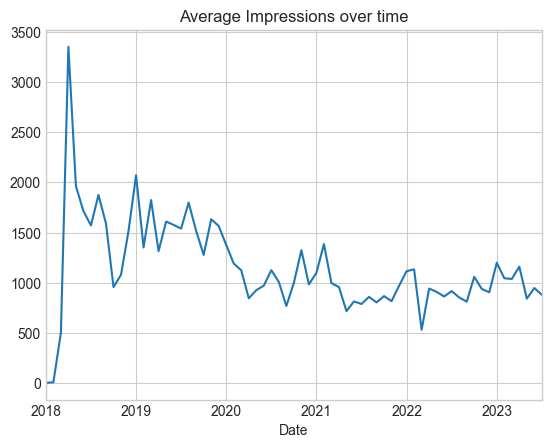

In [27]:
# calculate the mean impressions per month
mmi = valid_impressions["Impressions"].resample("M").mean()

# forward fill the data for months with empty values and generate a line plot
ax = mmi.fillna(method="ffill").plot(title="Average Impressions over time")

plt.show();

### QUESTION: When is the best time to post on LinkedIn?

In [28]:
# group the dataframe by content type and time period the post was made
cbt = (
    valid_impressions.groupby(["Content Type", "Time Period"])["Engagements"]
    .mean()
    .reset_index()
)

time_period_order = ["morning", "afternoon", "evening"]

# arrange the time period in order of morning, afternoon, and evening.
cbt["Time Period"] = pd.Categorical(
    cbt["Time Period"], categories=time_period_order, ordered=True
)

# sort the grouped dataframe by time period order
cbt = cbt.sort_values(["Content Type", "Time Period"])
cbt.reset_index(drop=True, inplace=True)

In [29]:
# The unique contents
cbt["Content Type"].unique()

array(['Document', 'Link', 'Photo', 'Poll', 'Text', 'Video'], dtype=object)

In [30]:
# slice the grouped dataframe into content types
document = cbt.iloc[:1]
document.name = "Document"

link = cbt.iloc[1:4]
link.name = "Links"

photo = cbt.iloc[4:7]
photo.name = "Photos"

text = cbt.iloc[9:12]
text.name = "Texts"

video = cbt.iloc[12:]
video.name = "Videos"

content = (document, link, photo, text, video)

In [31]:
# create a function that plots a Bokeh bar chart for the time period data.
def plot_bar(df):
    p = figure(title=df.name, x_range=list(df["Time Period"]), height=300, width=400)

    p.vbar(x="Time Period", top="Engagements", color="#99CCFF", source=df, width=0.8)

    p.axis.major_tick_out = 0

    p.xgrid.grid_line_color = None

    p.yaxis.axis_label = "Average Engagement"
    p.yaxis.minor_tick_out = 0
    p.y_range.start = 0
    p.y_range.end = 500

    return p

In [32]:
# import the gridplot function to display the plots in a gridplot
from bokeh.layouts import gridplot

# create an empty list and append the bar plots in list
plots = []
for c in content:
    plot = plot_bar(c)
    plots.append(plot)

# create a 2x2 layout for the plots and display it
layout = gridplot(plots, ncols=2, toolbar_location=None)
show(layout)

### QUESTION: What type of content has the broadest appeal?

In [33]:
# group sliced dataframe by content type and calaculate the mean "Organic Reach"
org_reach = (
    valid_impressions.groupby("Content Type")["Organic Impressions"]
    .mean()
    .reset_index()
)

# sort the grouped in descending order
org_reach.sort_values("Organic Impressions", ascending=False, inplace=True)

In [34]:
# create a bar chart showing the average organic reach by content type
from bokeh.plotting import figure, show

x_range = org_reach["Content Type"]
y_range = org_reach["Organic Impressions"]

p = figure(
    title="Average organic impressions of content",
    x_range=x_range,
    height=400,
    width=600,
    y_axis_label="Average Organic Impressions",
)

p.vbar(x=x_range, top=y_range, width=0.8)

p.yaxis.minor_tick_out = 0
p.y_range.start = 1000

show(p)

### What type of contents have the most authentic engagements?

In [35]:
# group sliced dataframe by content type and calaculate the mean "Organic Reach"
org_reach = (
    valid_impressions.groupby("Content Type")["Organic Impressions"]
    .mean()
    .reset_index()
)

# sort the grouped in descending order
org_reach.sort_values("Organic Impressions", ascending=False, inplace=True)

In [36]:
# create a bar chart showing the average organic reach by content type
from bokeh.plotting import figure, show

x_range = org_reach["Content Type"]
y_range = org_reach["Organic Impressions"]

p = figure(
    title="Average organic impressions of content",
    x_range=x_range,
    height=400,
    width=600,
    y_axis_label="Average Organic Impression",
)

p.vbar(x=x_range, top=y_range, width=0.8)

p.yaxis.minor_tick_out = 0
p.y_range.start = 1000

show(p)